In [10]:
import pandas as pd
import graphviz as gv
import matplotlib.pyplot as plt

In [102]:
# events — датасет с событиями. Колонки:
# timestamp — время события
# visitorid — идентификатор пользователя
# event — тип события ['view', 'addtocart', 'transaction']
# itemid — идентификатор объекта
# transactionid — идентификатор транзакции, если она проходила
dfev=pd.read_csv('events.csv.zip')
# добавление читаемого столбца даты/времени
dfev['datetime'] = pd.to_datetime(dfev['timestamp'], unit='ms')

dfev.head()

,timestamp,visitorid,event,itemid,transactionid,datetime
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106


In [85]:
duplicates = dfev.index.duplicated()

if any(duplicates):
    print("Датасет содержит повторяющиеся индексы.")
    print("Индексы, которые дублируются:", dfev.index[duplicates])
else:
    print("Датасет не содержит повторяющихся индексов.")

Датасет не содержит повторяющихся индексов.


In [3]:
# уникальные события
dfev['event'].unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

In [77]:
# подготовка сета с законченными транзацкиями
dfev_tr = dfev[dfev['transactionid'].notna()]
dfev_tr.head()

,timestamp,visitorid,event,itemid,transactionid,datetime
130,1433222276276,599528,transaction,356475,4000.0,2015-06-02 05:17:56.276
304,1433193500981,121688,transaction,15335,11117.0,2015-06-01 21:18:20.981
418,1433193915008,552148,transaction,81345,5444.0,2015-06-01 21:25:15.008
814,1433176736375,102019,transaction,150318,13556.0,2015-06-01 16:38:56.375
843,1433174518180,189384,transaction,310791,7244.0,2015-06-01 16:01:58.180


In [5]:
# разбивка транзакционной выборки на до и после 1 июля
df_before = dfev_tr[dfev_tr['datetime'] <= pd.Timestamp('2015-07-01')]
df_after = dfev_tr[dfev_tr['datetime'] > pd.Timestamp('2015-07-01')]

# топ 3 товара, проданных до 1 июля включительно
top_items = df_before['itemid'].value_counts().head(3)
top_items

119736    36
369447    31
7943      30
Name: itemid, dtype: int64

In [6]:
# (после первого июля уже были другие товары в топе)
top_items_ = df_after['itemid'].value_counts().head(3)
top_items_

461686    110
213834     89
119736     61
Name: itemid, dtype: int64

In [7]:
# полное количество транзакций до 1 июля
total_transactions = len(df_before)

# доля продаж топ 3 товаров в общем кол-ве транзакций до 1 июля
percentage_top_items = (top_items.sum() / total_transactions) * 100

print("\nдоля(%) продаж топ 3 товаров в общем кол-ве транзакций до 1 июля: {:.2f}%".format(percentage_top_items))


доля(%) продаж топ 3 товаров в общем кол-ве транзакций до 1 июля: 1.00%


In [9]:
# всего продаж после 1 июля
total_transactions_after = len(df_after)
# получим список itemid, которые входили в топ 3 до 1 июля
top_items_list = list(top_items.index)
# определить количество транзакций после 1 июля с топами из до 1 июля
top_items_count_after = df_after[df_after['itemid'].isin(top_items_list)].shape[0]

# какая доля продаж после 1 июля бывших топов
percentage_top_items_after = (top_items_count_after / total_transactions_after) * 100

print("\nдоля(%) продаж бывших топ 3 товаров в общем кол-ве транзакций после 1 июля: {:.3f}%".format(percentage_top_items_after))


доля(%) продаж бывших топ 3 товаров в общем кол-ве транзакций после 1 июля: 0.601%


In [19]:
# category_tree — файл с деревом категорий (можно восстановить дерево).
# category_id — идентификатор категорий
# parent_id — идентификатор родительской категории
df=pd.read_csv('category_tree.csv')
df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [38]:
# для корректности сопоставления categoryid	и parentid преобразуем в int
df['parentid'] = df['parentid'].fillna(-1).astype('int64')
df.sample(5)

,categoryid,parentid
1332,750,673
441,426,872
1485,1288,1182
1497,1507,1157
1595,1406,203


In [45]:
#построение графа для дерева категорий/подкатегорий
#(не для всех, а в качестве примера для одной из первых)
def find_root_category(category_id, df):#проверка, что категория входит в текущее дерево
    while True:
        parent_id = df.loc[df['categoryid'] == category_id, 'parentid'].iloc[0]
        if parent_id==-1:
            return category_id
        category_id = parent_id

# Получаем список уникальных корневых категорий
# root_categories = df[df['parentid'].isnull()]['categoryid'].tolist()
root_categories = df[df['parentid'] == -1]['categoryid'].tolist()

# Создаем отдельный граф для каждой корневой категории
for idx, root_category in enumerate(root_categories):
    if idx > 1:
        break

    graph = gv.Digraph(format='png')

    # Добавляем узлы (вершины) графа для текущей корневой категории и ее подкатегорий
    for index, row in df.iterrows():
        category_id = row['categoryid']
        parent_id = row['parentid']

        # Проверяем, что категория входит в дерево и ее корень соответствует текущей корневой категории
        if find_root_category(category_id, df) == root_category:
            if parent_id==-1:
                graph.node(str(category_id), label=f"{category_id} (Root)")
            else:
                graph.node(str(category_id), label=f"{category_id}")
                graph.edge(str(parent_id), str(category_id))

    # Сохраняем построенный граф в файл
    graph.render(f'category_graph_{idx}', view=True)


![](category_graph_1.png)

In [47]:
# item_properties — файл с свойствами товаров.
# timestamp — момент записи значения свойства
# item_id — идентификатор объекта
# property — свойство, кажется, они все, кроме категории, захешированы
# value — значение свойства
dfit1=pd.read_csv('item_properties_part1.csv.zip')
dfit1.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [48]:
dfit1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 335.7+ MB


In [47]:
dfit2=pd.read_csv('item_properties_part2.csv.zip')
dfit2.head()

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062


In [48]:
# li1=dfit1['property'].unique().tolist()
# li2=dfit2['property'].unique().tolist()
# количество уникальных свойств товаров суммарно по двум сетам
se = set(dfit1['property'].unique()).union(set(dfit2['property'].unique()))
len(se)

1104

In [49]:
# (в двух сетах есть повторяющиеся свойства)
len(dfit1['property'].unique())+len(dfit2['property'].unique())

2191

In [50]:

# Исследование количества событий до и после 1 июля
events_before_count = len(df_before)
events_after_count = len(df_after)

# Сравнение распределения типов событий до и после 1 июля
events_type_distribution_before = df_before['event'].value_counts()
events_type_distribution_after = df_after['event'].value_counts()

# Анализ популярности товаров
top_popular_items_before = df_before['itemid'].value_counts().head(10)
top_popular_items_after = df_after['itemid'].value_counts().head(10)

# Анализ уникальных пользователей
unique_visitors_before = df_before['visitorid'].nunique()
unique_visitors_after = df_after['visitorid'].nunique()
# Вывод результатов
print("Количество событий до 1 июля:", events_before_count)
print("Количество событий после 1 июля:", events_after_count)
print("\nРаспределение типов событий до 1 июля:")
print(events_type_distribution_before)
print("\nРаспределение типов событий после 1 июля:")
print(events_type_distribution_after)
print("\nТоп популярных товаров до 1 июля:")
print(top_popular_items_before)
print("\nТоп популярных товаров после 1 июля:")
print(top_popular_items_after)
print("\nКоличество уникальных пользователей до 1 июля:", unique_visitors_before)
print("Количество уникальных пользователей после 1 июля:", unique_visitors_after)


Количество событий до 1 июля: 9654
Количество событий после 1 июля: 12803

Распределение типов событий до 1 июля:
transaction    9654
Name: event, dtype: int64

Распределение типов событий после 1 июля:
transaction    12803
Name: event, dtype: int64

Топ популярных товаров до 1 июля:
119736    36
369447    31
7943      30
461686    23
318333    23
17478     22
312728    19
382885    18
48030     16
379520    16
Name: itemid, dtype: int64

Топ популярных товаров после 1 июля:
461686    110
213834     89
119736     61
445351     43
248455     38
334401     28
312728     27
441852     27
48030      25
320130     25
Name: itemid, dtype: int64

Количество уникальных пользователей до 1 июля: 5198
Количество уникальных пользователей после 1 июля: 6643


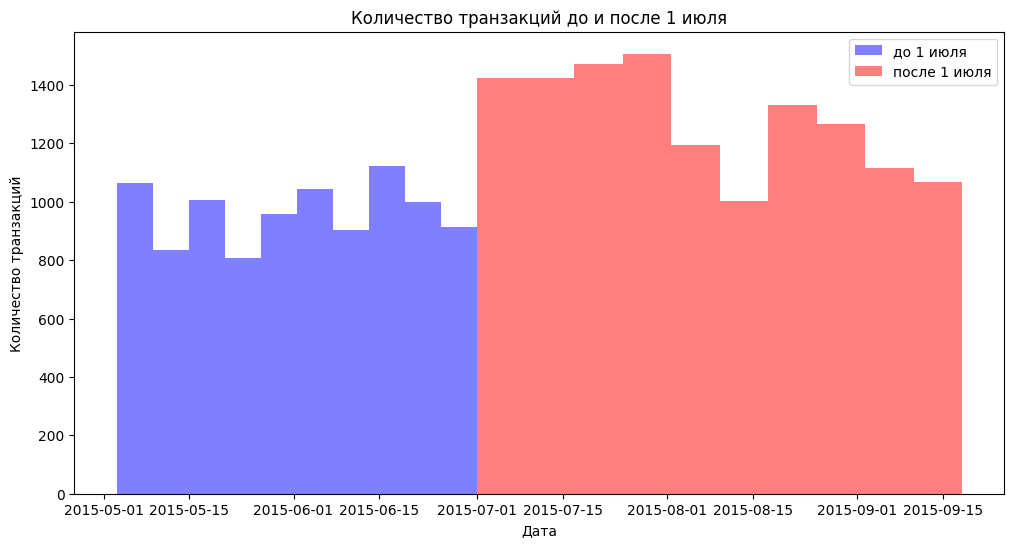

In [44]:

# Создаем гистограмму для количества транзакций до и после 1 июля
plt.figure(figsize=(12, 6))

# Гистограмма для данных до 1 июля
plt.hist(df_before['datetime'], bins=10, alpha=0.5, color='b', label='до 1 июля')

# Гистограмма для данных после 1 июля
plt.hist(df_after['datetime'], bins=10, alpha=0.5, color='r', label='после 1 июля')

plt.xlabel('Дата')
plt.ylabel('Количество транзакций')
plt.title('Количество транзакций до и после 1 июля')
plt.legend()

# Отображаем гистограмму
plt.show()

In [ ]:
# в целом заметно, что интенсивность продаж во втором периоде больше

In [54]:
# проверить корректность датасета - выполняется ли просмотр и добавление в корзину перед транзакцией
def check_order_of_events(df):
    for _, group in df.groupby(['itemid', 'visitorid']):
        has_transaction = any(group['event'] == 'transaction')
        has_addtocart = any(group['event'] == 'addtocart')
        has_view = any(group['event'] == 'view')

        if has_transaction and not has_addtocart:
            return False
        if has_addtocart and not has_view:
            return False

    return True

if check_order_of_events(dfev):
    print("Для каждой комбинации itemid и visitorid существует добавление в корзину перед транзакцией и просмотр перед добавлением в корзину.")
else:
    print("Не для каждой комбинации itemid и visitorid существует добавление в корзину перед транзакцией и просмотр перед добавлением в корзину.")



Не для каждой комбинации itemid и visitorid существует добавление в корзину перед транзакцией и просмотр перед добавлением в корзину.


In [56]:
# если рассуждать, что транзакции должны предшествовать события просмотра и добавления в корзину
# для каждого сочетания товара и покупателя, то следует исключить ряды,
# для которых не было всей цепочки, т.е. транзакция без добавления в корзину, или добавление в корзину без просмотра
# найти такие ряды
def check_order_of_events(df):
    invalid_rows = []

    for _, group in df.groupby(['itemid', 'visitorid']):
        has_transaction = any(group['event'] == 'transaction')
        has_addtocart = any(group['event'] == 'addtocart')
        has_view = any(group['event'] == 'view')

        if has_transaction and not has_addtocart:
            invalid_rows.extend(group.index)
        if has_addtocart and not has_view:
            invalid_rows.extend(group.index)

    return df.loc[invalid_rows]

invalid_rows_df = check_order_of_events(dfev)

if not invalid_rows_df.empty:
    print("Датасет с неверными строками:")
    print(invalid_rows_df)
else:
    print("Нет неверных строк в датасете.")
invalid_rows_df.head(10)    

Датасет с неверными строками:
             timestamp  visitorid        event  itemid  transactionid  \
871355   1439663070866     325833    addtocart      19            NaN   
874476   1439663329849     325833  transaction      19          219.0   
645049   1438647361098     575295  transaction      25         8858.0   
645239   1438647305321     575295    addtocart      25            NaN   
1482986  1430780975099     234788    addtocart      33            NaN   
...                ...        ...          ...     ...            ...   
2439215  1437275507057     702551    addtocart  466740            NaN   
1005231  1440394435722     986471    addtocart  466843            NaN   
2262849  1436646881033     303092    addtocart  466861            NaN   
31858    1433265161227     841595    addtocart  466861            NaN   
728396   1438971634830     651300    addtocart  466864            NaN   

                       datetime  
871355  2015-08-15 18:24:30.866  
874476  2015-08-15 18:28:

,timestamp,visitorid,event,itemid,transactionid,datetime
871355,1439663070866,325833,addtocart,19,NaN,2015-08-15 18:24:30.866
874476,1439663329849,325833,transaction,19,219.0,2015-08-15 18:28:49.849
645049,1438647361098,575295,transaction,25,8858.0,2015-08-04 00:16:01.098
645239,1438647305321,575295,addtocart,25,NaN,2015-08-04 00:15:05.321
1482986,1430780975099,234788,addtocart,33,NaN,2015-05-04 23:09:35.099
1496938,1430780975099,234788,addtocart,33,NaN,2015-05-04 23:09:35.099
1472658,1430679538497,421498,addtocart,33,NaN,2015-05-03 18:58:58.497
2117186,1435941861118,1294980,addtocart,66,NaN,2015-07-03 16:44:21.118
338689,1434576680240,1233979,transaction,212,895.0,2015-06-17 21:31:20.240
343420,1434576582406,1233979,addtocart,212,NaN,2015-06-17 21:29:42.406


In [58]:
# ????
# предположительно из датасета надо исключить 22 тысячи рядов,
# которые не соответствуют логике событий view-addtocart-transaction
invalid_rows_df.to_csv('invalid_rows_df.csv')

In [61]:
# примем решение, считать некорректными только ряды, для которых не было добавления в корзину и были транзакции.
# (если допустить, что можно класть товары в корзину без просмотра)
# Находим все ряды, для которых для сочетания visitorid и itemid нет события addtocart
filtered_df = invalid_rows_df.groupby(['visitorid', 'itemid']).filter(lambda x: not any(x['event'] == 'addtocart'))

print("Ряды, для которых не существует события addtocart для сочетания visitorid и itemid:")
print(filtered_df)
# тогда потребуется удалить порядка 7тыс некорректных рядов

Ряды, для которых не существует события addtocart для сочетания visitorid и itemid:
             timestamp  visitorid        event  itemid  transactionid  \
376542   1434734011664      76757  transaction     320        16619.0   
390533   1434733878627      76757         view     320            NaN   
1007229  1440393876422     434507  transaction     546          408.0   
1011942  1440393693084     434507         view     546            NaN   
2506910  1437508500754     385857  transaction     563        12935.0   
...                ...        ...          ...     ...            ...   
1511731  1430881103410     409939  transaction  465622        17623.0   
47071    1433350379996    1339801  transaction  465943         6395.0   
58886    1433350130723    1339801         view  465943            NaN   
1262617  1441586798593     310032  transaction  466114        10314.0   
1174102  1441148046859    1084561  transaction  466135         8748.0   

                       datetime  
37654

In [103]:
# удалить некорректные ряды
print(dfev.shape)
dfev.drop(filtered_df.index, inplace=True)
print(dfev.shape)

(2756101, 6)
(2749113, 6)


In [65]:
dfev.to_csv('dfev.csv')

In [104]:
# определим конверсию для двух периодов
df_bef = dfev[dfev['datetime'] <= pd.Timestamp('2015-07-01')]
df_aft = dfev[dfev['datetime'] > pd.Timestamp('2015-07-01')]
# отфильтровать ряды, которые удовлетворяют условию, что при группировке по пользователю-товару присутствует транзакция
trans_bef = df_bef.groupby(['visitorid', 'itemid']).filter(lambda x: any(x['event'] == 'transaction'))
trans_bef.head(10)

,timestamp,visitorid,event,itemid,transactionid,datetime
19,1433221078505,158090,addtocart,10572,NaN,2015-06-02 04:57:58.505
27,1433222147345,1076270,view,262799,NaN,2015-06-02 05:15:47.345
112,1433221941632,599528,addtocart,356475,NaN,2015-06-02 05:12:21.632
130,1433222276276,599528,transaction,356475,4000.0,2015-06-02 05:17:56.276
164,1433222646781,529601,view,161166,NaN,2015-06-02 05:24:06.781
304,1433193500981,121688,transaction,15335,11117.0,2015-06-01 21:18:20.981
330,1433191584678,850173,view,243470,NaN,2015-06-01 20:46:24.678
381,1433194701554,539910,view,385201,NaN,2015-06-01 21:38:21.554
418,1433193915008,552148,transaction,81345,5444.0,2015-06-01 21:25:15.008
420,1433193032159,639964,view,360258,NaN,2015-06-01 21:10:32.159


In [106]:
trans_aft = df_aft.groupby(['visitorid', 'itemid']).filter(lambda x: any(x['event'] == 'transaction'))

In [110]:
# Группировка и фильтрация для подсчета количества групп, удовлетворяющих условию
# count_groups = df.groupby(['visitorid', 'itemid']).filter(lambda x: any((x['event'] == 'view') | (x['event'] == 'addtocart'))).groupby(['visitorid', 'itemid']).ngroups

# найти общее количество взаимодействий пользователь-товар
all_bef = df_bef.groupby(['visitorid', 'itemid']).ngroups
all_aft = df_aft.groupby(['visitorid', 'itemid']).ngroups

# найти конверсию
print(f"Конверсия до 1 июля:{trans_bef.groupby(['visitorid', 'itemid']).ngroups/all_bef}")
print(f"Конверсия после 1 июля:{trans_aft.groupby(['visitorid', 'itemid']).ngroups/all_aft}")

Конверсия до 1 июля:0.008934952378995942
Конверсия после 1 июля:0.008818147927898385


# генерация факторов

In [4]:
# что-то похожее на kaggle https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset/data
events = pd.read_csv("dfev.csv") #датасет с очищенными некорректными рядами
properties = pd.concat([
    pd.read_csv("item_properties_part1.csv.zip"),
    pd.read_csv("item_properties_part2.csv.zip")
])
categories = pd.read_csv("category_tree.csv")
events['event_datetime'] = pd.to_datetime(events['timestamp'], unit = 'ms')
properties['event_datetime'] = pd.to_datetime(properties['timestamp'], unit = 'ms')
events['day_of_week'] = events['event_datetime'].map(lambda x: x.weekday())
events['Year'] = events['event_datetime'].map(lambda x: x.year)
events['Month'] = events['event_datetime'].map(lambda x: x.month)
events['Day'] = events['event_datetime'].map(lambda x: x.day)
events['Hour'] = events['event_datetime'].map(lambda x: x.hour)
events['minute'] = events['event_datetime'].map(lambda x: x.minute)
def get_time_periods(hour):
    if hour >= 3 and hour < 7:
        return 'Dawn'
    elif hour >= 7 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 16:
        return 'Afternoon'
    elif hour >= 16 and hour < 22:
        return 'Evening'
    else:
        return 'Night'
    
events['Day Period'] = events['Hour'].map(get_time_periods)
events['Day Period'].value_counts()
# Возьмем только самые распространенные proprties, например топ 20 (при построении модели можно играть)
top_properties = properties.drop_duplicates(['itemid', 'property']).groupby("property")['itemid'].count().sort_values(ascending=False)[:20]
properties_filtered = properties[properties['property'].isin(set(top_properties.index))]
properties_filtered.shape

In [12]:
# топ 20 property
properties_filtered.head(20)

,timestamp,itemid,property,value,event_datetime
0,1435460400000,460429,categoryid,1338,2015-06-28 03:00:00
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00
4,1431831600000,156781,917,828513,2015-05-17 03:00:00
5,1436065200000,285026,available,0,2015-07-05 03:00:00
7,1431831600000,264312,6,319724,2015-05-17 03:00:00
8,1433646000000,229370,202,1330310,2015-06-07 03:00:00
10,1439089200000,450113,888,1038400 45956 n504.000,2015-08-09 03:00:00
12,1439694000000,264319,227,1283144 353870,2015-08-16 03:00:00
13,1439694000000,348323,839,1026952 1162729,2015-08-16 03:00:00


# изучение значений свойств

In [67]:
prop2=properties_filtered.groupby(['property', 'itemid']).filter(lambda x: True)

# Разделяем строки в столбце 'column_name' на множества значений
prop2['svalue'] = prop2['value'].apply(lambda x: set(x.split(' ')))

# Объединяем множества значений в одно множество
unique_values = set.union(*prop2['svalue'])

# Определяем количество уникальных значений
num_unique_values = len(unique_values)
print('Количество уникальных значений:', num_unique_values)

Количество уникальных значений: 1327644


In [70]:
# для комбинации товара и свойства тогут наблюдаться разные значения
prop[prop.duplicated(['property', 'itemid'], keep=False)].sort_values(by=['property', 'itemid'])[:10]

,timestamp,itemid,property,value,event_datetime
140794,1440298800000,305,202,595784,2015-08-23 03:00:00
339577,1433646000000,305,202,1330191,2015-06-07 03:00:00
538360,1442113200000,305,202,595784,2015-09-13 03:00:00
737143,1439089200000,305,202,595784,2015-08-09 03:00:00
935926,1437879600000,305,202,595784,2015-07-26 03:00:00
7230084,1433041200000,305,202,1330191,2015-05-31 03:00:00
7428867,1436670000000,305,202,1330191,2015-07-12 03:00:00
7627650,1435460400000,305,202,1330191,2015-06-28 03:00:00
7826433,1432436400000,305,202,1330191,2015-05-24 03:00:00
8025216,1436065200000,305,202,1330191,2015-07-05 03:00:00


In [22]:
# определить наиболее часто присутствующие значения свойств
# Создаем словарь для подсчета частот
value_frequencies = {}

# Подсчитываем частоту каждого уникального значения
for value_set in prop2['svalue']:
    for value in value_set:
        if value in value_frequencies:
            value_frequencies[value] += 1
        else:
            value_frequencies[value] = 1

# Выводим частоты уникальных значений
print('Частоты уникальных значений:')
for value, frequency in value_frequencies.items():
    print(f'{value}: {frequency}')

Частоты уникальных значений:
1: 615361
0: 538254
2: 188
91: 3
44: 15
72: 3408
92: 12
53: 387
74: 8946
47: 2684
50: 4
76: 12
89: 255
68: 49
52: 320
26: 8
96: 88
77: 90
88: 39
16: 42
98: 9
14: 60
45: 27
95: 5
86: 17
21: 7
84: 9
56: 6
972: 15
598: 10
614: 10
615: 26
379: 3
675: 16
143: 15
968: 9
100: 11
826: 6
724: 1
924: 13
791: 17
945: 1
941: 6
178: 9
523: 59
597: 3
697: 1
642: 9079
987: 18
486: 111
930: 18
762: 18
183: 18
831: 66
750: 198
895: 22
655: 82
494: 21
721: 18
711: 18
626: 18
318: 54
460: 24
887: 35
438: 4380
491: 19953
822: 1613
319: 3000
637: 888
220: 3927
819: 848
929: 1578
282: 11615
429: 4362
463: 1799
452: 344
963: 56
706: 2625
126: 626
519: 1915
449: 1358
421: 4075
496: 3513
546: 24882
559: 186
466: 87
970: 2506
888: 58
957: 2058
947: 934
274: 1015
712: 174
208: 1111
396: 1709
327: 766
558: 2626
469: 108
315: 1362
681: 642
176: 5387
199: 622
498: 2627
256: 4468
338: 1932
225: 103
329: 440
528: 263
691: 495
507: 1232
361: 124
279: 20
925: 234
381: 1207
161: 98
424: 49
7

In [ ]:
# Сортируем значения по убыванию частоты
sorted_values = sorted(value_frequencies.items(), key=lambda x: x[1], reverse=True)

# Выводим отсортированные значения
print('Частоты уникальных значений, отсортированные по убыванию:')
for value, frequency in sorted_values[:30]:
    # print(f'{value}: {frequency}')
    pass
# Преобразуем отсортированный список кортежей в DataFrame для удобства визуализации
frequencies_df = pd.DataFrame(sorted_values, columns=['Value', 'Frequency'])

In [46]:
frequencies_df[frequencies_df.Frequency<9000]

,Value,Frequency,Bin
195,388993,8953,1
196,74,8946,1
197,1023101,8861,1
198,176547,8849,1
199,1090966,8825,1
...,...,...,...
165741,706635,1,0
165742,n713320836.000,1,0
165743,n713323548.000,1,0
165744,n713315280.000,1,0


In [41]:
frequencies_df.shape

(165746, 3)

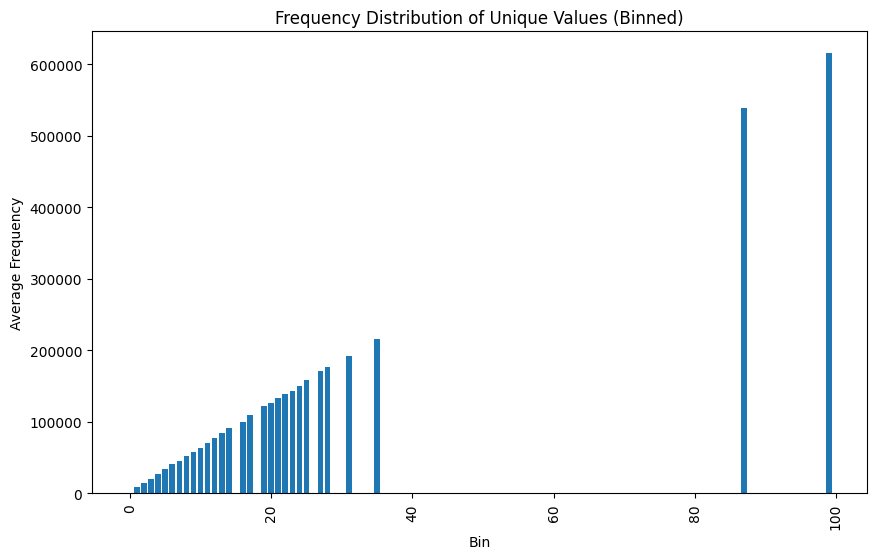

In [27]:
# Определяем количество бинов для разделения данных
num_bins = 100 # Выберите разумное количество бинов

# Разделяем данные на бины
frequencies_df['Bin'] = pd.cut(frequencies_df['Frequency'], bins=num_bins, labels=False)

# Считаем среднюю частоту для каждого бина
binned_frequencies = frequencies_df.groupby('Bin')['Frequency'].mean().reset_index()

# Построение гистограммы частот
plt.figure(figsize=(10, 6))
plt.bar(binned_frequencies['Bin'], binned_frequencies['Frequency'])
plt.xlabel('Bin')
plt.ylabel('Average Frequency')
plt.title('Frequency Distribution of Unique Values (Binned)')
plt.xticks(rotation=90) # Поворот меток по оси X для лучшей читаемости
plt.ylim(bottom=0) # Устанавливаем нижний предел оси Y в 0
plt.show()

In [49]:
# если отбросить всего 1 крайний бин из 100 бинов, 
# то количество уникальных значений для свойств уменьшится с 165746 до 311
# т.е. для факторизационной машины будет на 3 порядка меньше таблицы при потере 1% значений свойств товаров
print(frequencies_df.shape)
print(frequencies_df[frequencies_df.Bin>=1].shape)

(165746, 3)
(311, 3)


следует ли создать категориальный признак на основе 165746 значений для кодирования свойства товара???

In [143]:
%pip install scikit-surprise


     ---------------------------------------- 0.0/772.0 kB ? eta -:--:--
     --- --------------------------------- 71.7/772.0 kB 991.0 kB/s eta 0:00:01
     ---------- --------------------------- 204.8/772.0 kB 2.1 MB/s eta 0:00:01
     ------------------------ ------------- 491.5/772.0 kB 3.4 MB/s eta 0:00:01
     -------------------------------------  768.0/772.0 kB 4.1 MB/s eta 0:00:01
     -------------------------------------  768.0/772.0 kB 4.1 MB/s eta 0:00:01
     -------------------------------------  768.0/772.0 kB 4.1 MB/s eta 0:00:01
     -------------------------------------  768.0/772.0 kB 4.1 MB/s eta 0:00:01
     -------------------------------------  768.0/772.0 kB 4.1 MB/s eta 0:00:01
     -------------------------------------- 772.0/772.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-win_amd64.whl size=1097905 

In [118]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(events, test_size=0.3, shuffle=False)

# коллаборативная фильтрация

In [219]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
import pandas as pd
import numpy as np
from collections import defaultdict

# Загрузка данных
events = pd.read_csv("dfev.csv")#датасет с очищенными некорректными рядами
properties = pd.concat([
    pd.read_csv("item_properties_part1.csv.zip"),
    pd.read_csv("item_properties_part2.csv.zip")
])

# Использование только транзакции для оценки предпочтений
transactions = events[events["event"] == "transaction"]
transactions["rating"] = 1  # Всем транзакциям присваиваем рейтинг 1

reader = Reader(rating_scale=(1, 1))
data = Dataset.load_from_df(transactions[["visitorid", "itemid", "rating"]].rename(columns={"visitorid": "uid", "itemid": "iid"}), reader)

# Разбиение данных на обучающую и тестовую выборки
trainset, testset = train_test_split(data, test_size=.20, shuffle=False)

# Создание и обучение модели
sim_options = {
    'name': 'cosine',
    'user_based': True  # коллаборативная фильтрация по пользователям
}
model = KNNWithMeans(sim_options=sim_options)
model.fit(trainset)

# Тестирование модели
predictions = model.test(testset)

# Функция для получения топ-N рекомендаций для каждого пользователя
def get_top_n(predictions, n=3):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Сортировка предсказаний для каждого пользователя и выбор n лучших
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Получаем топ-N рекомендаций для всех пользователей в тестовой выборке
top_n_recommendations = get_top_n(predictions, n=3)

# Выводим рекомендации для 10 случайных пользователей
for i,(uid, user_ratings) in enumerate(top_n_recommendations.items()):
    print(uid, [iid for (iid, _) in user_ratings[:10]])
    if i>10:break

from collections import defaultdict

def precision_at_k(top_n, testset, k=3):
    '''Вычисляет среднюю точность на k для предложенного набора рекомендаций.'''
    hit = 0
    total = 0
    
    for uid, user_ratings in top_n.items():
        # Фильтрация тестовых оценок для этого пользователя
        actual_items = [item for (user, item, rating) in testset if user == uid]
        # Пересечение реальных предпочтений пользователя и топ-3 предсказаний
        hit += len(set(actual_items) & set([iid for (iid, _) in user_ratings]))
        total += k
    
    # Вычисление точности на k
    if total == 0:
        return 0

    return hit / total

# Применение функций
predictions = model.test(testset)
top_n = get_top_n(predictions, n=3)
precision = precision_at_k(top_n, testset, k=3)
print(f"Precision@3: {precision:.4f}")

C:\Users\v.volkov\AppData\Local\Temp\ipykernel_1968\3536762891.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions["rating"] = 1  # Всем транзакциям присваиваем рейтинг 1


Computing the cosine similarity matrix...
Done computing similarity matrix.
288699 [320496]
1014131 [183137]
816161 [90894]
329317 [280845, 461686, 218794]
371606 [294242, 249804, 77733]
896066 [132068, 374835, 263008]
1150086 [4067, 270525, 109498]
1016281 [420960]
1225435 [282942, 192582, 192582]
1297062 [389200, 436056, 33775]
771611 [394660]
705542 [264521, 102471, 244458]
Precision@3: 0.4232


коллаборативная фильтрация показала хорошее предсказание 42% по сравнению с факторизационной машиной ниже:

In [220]:
%pip install lightfm

     ---------------------------------------- 0.0/316.4 kB ? eta -:--:--
     ----- --------------------------------- 41.0/316.4 kB 2.0 MB/s eta 0:00:01
     ------- ----------------------------- 61.4/316.4 kB 409.6 kB/s eta 0:00:01
     ---------- -------------------------- 92.2/316.4 kB 476.3 kB/s eta 0:00:01
     ------------- ---------------------- 122.9/316.4 kB 400.9 kB/s eta 0:00:01
     ---------------- ------------------- 143.4/316.4 kB 218.6 kB/s eta 0:00:01
     ---------------- ------------------- 143.4/316.4 kB 218.6 kB/s eta 0:00:01
     ------------------- ---------------- 174.1/316.4 kB 184.1 kB/s eta 0:00:01
     ------------------- ---------------- 174.1/316.4 kB 184.1 kB/s eta 0:00:01
     ------------------- ---------------- 174.1/316.4 kB 184.1 kB/s eta 0:00:01
     ----------------------- ------------ 204.8/316.4 kB 161.7 kB/s eta 0:00:01
     ----------------------- ------------ 204.8/316.4 kB 161.7 kB/s eta 0:00:01
     -------------------------- --------- 235.5

# факторизационная машина

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import coo_matrix, hstack
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
events = pd.read_csv("dfev.csv")#датасет с очищенными некорректными рядами
properties = pd.concat([
    pd.read_csv("item_properties_part1.csv.zip"),
    pd.read_csv("item_properties_part2.csv.zip")
])
categories = pd.read_csv("category_tree.csv")

c:\Users\v.volkov\AppData\Local\miniconda3\envs\env3.9\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [5]:
# Фильтрация событий покупок, т.к. только на купленных товарах предполагается предлагать пользователю к покупке товары
purchased_events = events[events['event'] == 'transaction']
print("Размерность исходного датасета:", purchased_events.shape)
# Группировка по visitorid и подсчет уникальных itemid для каждого пользователя
user_purchases = purchased_events.groupby('visitorid')['itemid'].nunique().reset_index(name='num_purchases')

# Отбор пользователей, которые купили более 1 товара (обучать на постоянных покупателях)
filtered_users = user_purchases[user_purchases['num_purchases'] > 1]['visitorid'].tolist()

# Фильтрация событий, оставляя только те, которые соответствуют отфильтрованным пользователям
purchased_events = purchased_events[purchased_events['visitorid'].isin(filtered_users)]

# Проверка размерности отфильтрованного датасета
print("Размерность отфильтрованного датасета:", purchased_events.shape)

Размерность исходного датасета: (20121, 7)
Размерность отфильтрованного датасета: (11044, 7)


In [6]:
# Подсчет частоты покупок каждого товара
item_frequencies = purchased_events['itemid'].value_counts().reset_index().rename(columns={'index': 'itemid', 'itemid': 'frequency'})

# Выбор порога частоты для отбора товаров
# отбрасываем товары, купленные реже, чем 2 раза
threshold_frequency = 2
# Отбор товаров, частота покупок которых выше порога
filtered_items = item_frequencies[item_frequencies['frequency'] >=threshold_frequency]['itemid'].tolist()

print(f"Количество товаров после отбора: {len(filtered_items)}")

# Фильтрация событий, оставляя только те, которые соответствуют отфильтрованным товарам
purchased_events = purchased_events[purchased_events['itemid'].isin(filtered_items)]

# Проверка размерности отфильтрованного датасета
print("Размерность отфильтрованного датасета:", purchased_events.shape)

Количество товаров после отбора: 1946
Размерность отфильтрованного датасета: (5498, 7)


In [7]:
# Фильтрация топ 20 наиболее частых свойств для товаров
top_properties = properties.drop_duplicates(['itemid', 'property']).groupby("property")['itemid'].count().sort_values(ascending=False)[:20]
properties_filtered = properties[properties['property'].isin(set(top_properties.index))]
# реально купленных товаров, на которых стоит строить предсказания, сильно меньше, чем есть в ассортименте
print(len(properties_filtered['itemid'].unique()))
print(len(purchased_events['itemid'].unique()))


417053
1946


In [8]:
# Отбрасываем строки из properties_filtered, где itemid не присутствует в purchased_events
properties_filtered = properties_filtered[properties_filtered['itemid'].isin(purchased_events['itemid'].unique())]
# Отбрасываем строки из purchased_events, где itemid не присутствует в filtered_properties
purchased_events = purchased_events[purchased_events['itemid'].isin(properties_filtered['itemid'].unique())]

In [9]:
print("уникальных пользователей",len(purchased_events['visitorid'].unique()))
print("уникальных товаров в датасете товаров",len(properties_filtered['itemid'].unique()))
print("уникальных товаров среди купленных",len(purchased_events['itemid'].unique()))
setprop=set(properties_filtered['itemid'].unique())
setpurch=set(purchased_events['itemid'].unique())
print(f"отличия датасетов на предмет itemid: {setprop.difference(setpurch)}")
# отличий нет, что и требуется для формирования матриц

уникальных пользователей 1350
уникальных товаров в датасете товаров 1923
уникальных товаров среди купленных 1923
отличия датасетов на предмет itemid: set()


In [10]:
# Разделяем значения свойств на отдельные подстроки и получаем все уникальные
unique_properties_set = set()
properties_filtered['value'].str.split().apply(unique_properties_set.update)
unique_properties_list = list(unique_properties_set)
# список значений свойств товаров очень большой. 
len(unique_properties_list)

18444

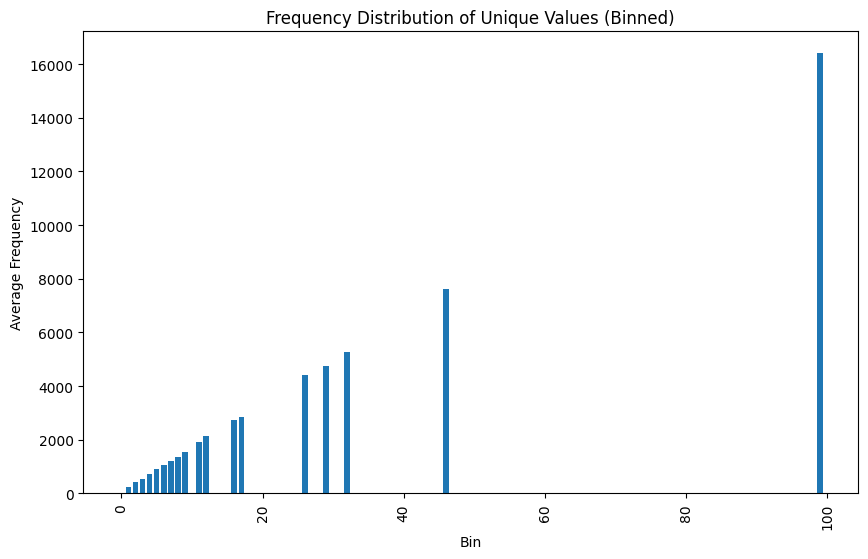

In [11]:
# Вычисляем частоту каждого уникального значения для  свойства
# пробуем уменьшить размерность
property_frequencies = properties_filtered['value'].str.split().explode().value_counts()
frequencies = property_frequencies.reset_index(name='Frequency').rename(columns={'index': 'value'})

# Определяем количество бинов для разделения данных
num_bins = 100 
# Разделяем данные на бины
frequencies['Bin'] = pd.cut(frequencies['Frequency'], bins=num_bins, labels=False)

# Считаем среднюю частоту для каждого бина
binned_frequencies = frequencies.groupby('Bin')['Frequency'].mean().reset_index()

# Построение гистограммы частот
plt.figure(figsize=(10, 6))
plt.bar(binned_frequencies['Bin'], binned_frequencies['Frequency'])
plt.xlabel('Bin')
plt.ylabel('Average Frequency')
plt.title('Frequency Distribution of Unique Values (Binned)')
plt.xticks(rotation=90) # Поворот меток по оси X для лучшей читаемости
plt.ylim(bottom=0) # Устанавливаем нижний предел оси Y в 0
plt.show()

In [12]:
# анализ показал, что 99% самых частовствречаемых свойств всего 155 из 18289
print(frequencies[frequencies.Bin>=1].shape)
print(frequencies[frequencies.Bin==0].shape)

(155, 3)
(18289, 3)


In [13]:
# # Создаем список всех уникальных значений свойств, которые попадают в бин с индексом 1 и выше
filtered_values = frequencies[frequencies['Bin'] >= 1]['value'].unique()
len(filtered_values)

155

In [14]:
# Кодируем идентификаторы пользователей

# LabelEncoder используется для того, чтобы получить 0-базед идентификаторы,
# т.к. на реальных visitorid и itemid идентификаторах получались матрицы огромных размеров
# используя для своих измерений реальные значения visitorid и itemid

visitorid_encoder = LabelEncoder()
purchased_events['visitorid_encoded']=visitorid_encoder.fit_transform(purchased_events['visitorid'])

itemid_encoder = LabelEncoder()
# Объединяем все уникальные идентификаторы товаров из обоих датасетов
all_itemids = np.concatenate([purchased_events['itemid'].unique(), properties_filtered['itemid'].unique()])
# Обучаем LabelEncoder на всех уникальных идентификаторах товаров
itemid_encoder.fit(all_itemids)
# Теперь преобразуем идентификаторы товаров в каждом датасете
purchased_events['itemid_encoded'] = itemid_encoder.transform(purchased_events['itemid'])
properties_filtered['itemid_encoded'] = itemid_encoder.transform(properties_filtered['itemid'])

# Теперь создаем матрицу взаимодействий с использованием закодированных идентификаторов
item_user_interactions = coo_matrix((np.ones(purchased_events.shape[0]), 
                                    (purchased_events['visitorid_encoded'], purchased_events['itemid_encoded'])))

# Проверим размерность получившейся матрицы
print("Размерность матрицы взаимодействий после кодирования:", item_user_interactions.shape)
# Кодирование отфильтрованных уникальных значений свойств товаров
property_encoder = LabelEncoder()
property_encoded = property_encoder.fit_transform(filtered_values)
property_to_code = dict(zip(filtered_values, property_encoded))
# Сопоставление каждого товара с его закодированными свойствами
def encode_properties(values):
    # Разделяем значения свойств и фильтруем их, оставляя только те, которые присутствуют в filtered_values
    return [property_to_code[val] for val in values.split() if val in property_to_code]

# Создаем пустые списки для данных матрицы признаков товаров
rows, cols, data = [], [], []
properties_filtered['encoded_values'] = properties_filtered['value'].apply(encode_properties)
for _, row in properties_filtered.iterrows():
    for val in row['encoded_values']:
        rows.append(row['itemid_encoded'])
        cols.append(val)
        data.append(1)

print(len(rows))
print(len(cols))
print(len(data))

item_features = coo_matrix((data, (rows, cols)), 
                           shape=(item_user_interactions.shape[1], len(filtered_values)))
# Проверка размерности матрицы признаков
print("Размерность матрицы признаков:", item_features.shape)

Размерность матрицы взаимодействий после кодирования: (1350, 1923)
108980
108980
108980
Размерность матрицы признаков: (1923, 155)


In [15]:

# Создаем модель without the loss='warp' parameter (using default logistic loss).
# https://github.com/lyst/lightfm/issues/690 
# с параметром loss='warp' в windows ядро питон умирает всегда на функции fit, никакие уменьшения матриц не помогли
model = LightFM()
# Обучение модели факторизационных машин с признаками товаров
model.fit(item_user_interactions, item_features=item_features, epochs=30, num_threads=2)
# Оценка модели
test_precision = precision_at_k(model, item_user_interactions, item_features=item_features, k=3).mean()
print(f'Test Precision@3: {test_precision}')


Test Precision@3: 0.0022222225088626146


Precision@3: 0.0022222225088626146 - плохой результат.

при запуске модели на неуменьшенных датасетах
Размерность матрицы взаимодействий: (10382, 10910)
Размерность матрицы признаков: (10910, 66148)

получился еще более низкий показатель
Precision@3: 0.0000963206

# XGBoost для задачи классификации

In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# events — датасет с событиями. Колонки:
# timestamp — время события
# visitorid — идентификатор пользователя
# event — тип события ['view', 'addtocart', 'transaction']
# itemid — идентификатор объекта
# transactionid — идентификатор транзакции, если она проходила
events = pd.read_csv("dfev.csv", index_col=0)#датасет с очищенными некорректными рядами
# item_properties — файл с свойствами товаров.
# timestamp — момент записи значения свойства
# item_id — идентификатор объекта
# property — свойство, кажется, они все, кроме категории, захешированы
# value — значение свойства
properties = pd.concat([
    pd.read_csv("item_properties_part1.csv.zip"),
    pd.read_csv("item_properties_part2.csv.zip")
])
# category_tree — файл с деревом категорий (можно восстановить дерево).
# category_id — идентификатор категорий
# parent_id — идентификатор родительской категории
categories = pd.read_csv("category_tree.csv")

# Добавление новых признаков
events['event_datetime'] = pd.to_datetime(events['timestamp'], unit='ms')
properties['event_datetime'] = pd.to_datetime(properties['timestamp'], unit='ms')
events['day_of_week'] = events['event_datetime'].map(lambda x: x.weekday())
events['Year'] = events['event_datetime'].map(lambda x: x.year)
events['Month'] = events['event_datetime'].map(lambda x: x.month)
events['Day'] = events['event_datetime'].map(lambda x: x.day)
events['Hour'] = events['event_datetime'].map(lambda x: x.hour)
events['minute'] = events['event_datetime'].map(lambda x: x.minute)

def get_time_periods(hour):
    if hour >= 3 and hour < 7:
        return 'Dawn'
    elif hour >= 7 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 16:
        return 'Afternoon'
    elif hour >= 16 and hour < 22:
        return 'Evening'
    else:
        return 'Night'

events['Day Period'] = events['Hour'].map(get_time_periods)


In [17]:
# Фильтрация событий 'view' и 'addtocart'
view_and_addtocart = events[(events['event'] == 'view') | (events['event'] == 'addtocart')]
# Фильтрация событий 'transaction'
transactions = events[events['event'] == 'transaction']
itemids_view_addtocart = set(view_and_addtocart['itemid'])
itemids_transaction = set(transactions['itemid'])
# Получение списка itemid, которые есть в событиях 'view' и 'addtocart', но их нет в событиях 'transaction'
itemids_missing_in_transaction = itemids_view_addtocart - itemids_transaction

In [18]:
# Вычисляем частоту бесполезных просмотров товаров, которые никогда не куплены
# пробуем уменьшить размерность
notrans_events = events[events['itemid'].isin(itemids_missing_in_transaction)]
frequencies = notrans_events['itemid'].value_counts()
frequencies = frequencies.reset_index(name='Frequency').rename(columns={'index': 'value'})
# Определяем количество бинов для разделения данных
num_bins = 100 
# Разделяем данные на бины
frequencies['Bin'] = pd.cut(frequencies['Frequency'], bins=num_bins, labels=False)
# анализ показал, что 99% просмотров приходится на 10082 товаров из 213782, которые никогда не куплены
# можно сильно облегчить базу за счет 1% товаров без существенного ухудшения качества
print(frequencies[frequencies.Bin>=1].shape)
print(frequencies[frequencies.Bin==0].shape)

# только эти товары стоит включить в обучающую базу, как не купленные
filtered_itemsid = frequencies[frequencies['Bin'] >= 1]['value'].unique()
len(filtered_itemsid)

(10082, 3)
(213782, 3)


10082

In [31]:
# это события с клиентами/товарами , которые часто смотрели и не купили и которые покупали
filtered_events = events[(events['itemid'].isin(filtered_itemsid)) | (events['event'] == 'transaction')]
filtered_events.shape

(789837, 14)

In [32]:
# добавить признак очередной покупки одинакового товара одним и тем же покупателем
filtered_events = filtered_events.sort_values('event_datetime', ascending=True)
# Отфильтровываем только транзакции
transactions = filtered_events[filtered_events['event'] == 'transaction'].copy()
# Генерируем временной индекс
transactions['time_index'] = range(1, len(transactions) + 1)
# Вычисляем кумулятивные покупки
transactions['cumulative_purchase'] = transactions.groupby(['visitorid', 'itemid'])['time_index'].rank(method='first')

# Добавляем информацию о кумулятивных покупках в исходный датафрейм
filtered_events = filtered_events.merge(transactions[['visitorid', 'itemid', 'event_datetime', 'cumulative_purchase']], 
                      how='left', 
                      on=['visitorid', 'itemid', 'event_datetime'])

# Заполняем пропуски нулями (для просмотров и добавлений в корзину, которые не завершились покупками)
filtered_events['cumulative_purchase'] = filtered_events['cumulative_purchase'].fillna(0)

In [33]:
filtered_events[:3]

,timestamp,visitorid,event,itemid,transactionid,datetime,event_datetime,day_of_week,Year,Month,Day,Hour,minute,Day Period,cumulative_purchase
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03 03:00:04.384,6,2015,5,3,3,0,Dawn,0.0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03 03:00:11.289,6,2015,5,3,3,0,Dawn,0.0
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03 03:00:13.048,6,2015,5,3,3,0,Dawn,0.0


In [34]:
# один и тот же клиент покупает один и тот же товар несколько раз
grouped_df = filtered_events.groupby(['visitorid','itemid'])[['visitorid','itemid','event_datetime','cumulative_purchase']]
print(grouped_df.filter(lambda x: (x['cumulative_purchase'] > 3).any()).sort_values(by=['visitorid','itemid','event_datetime']))

        visitorid  itemid          event_datetime  cumulative_purchase
83698      138131  119736 2015-05-17 19:24:41.461                  1.0
200914     138131  119736 2015-06-05 16:34:15.496                  2.0
227873     138131  119736 2015-06-10 02:41:22.646                  3.0
233387     138131  119736 2015-06-10 22:27:16.305                  4.0
9292       138131  318333 2015-05-04 22:53:02.360                  1.0
...           ...     ...                     ...                  ...
288355    1385029  382885 2015-06-20 17:52:45.625                  1.0
296254    1385029  382885 2015-06-22 04:47:51.485                  2.0
311446    1385029  382885 2015-06-24 17:46:32.778                  3.0
316218    1385029  382885 2015-06-25 14:18:45.893                  4.0
321026    1385029  382885 2015-06-26 04:29:40.311                  5.0

[116 rows x 4 columns]


In [35]:
filtered_events.shape

(789837, 15)

In [36]:
# оставить только самые популярные 20 свойств для дальнейшего использования
top_properties = properties.drop_duplicates(['itemid', 'property']).groupby("property")['itemid'].count().sort_values(ascending=False)[:20]
properties_filtered = properties[properties['property'].isin(set(top_properties.index))]
print(properties_filtered.shape)

(13563669, 5)


In [37]:
# уменьшаем размерность значений свойств, как уже было исследовано для факторизационных машин
property_frequencies = properties_filtered['value'].str.split().explode().value_counts()
frequencies = property_frequencies.reset_index(name='Frequency').rename(columns={'index': 'value'})
num_bins = 100 
# Разделяем данные на бины
frequencies['Bin'] = pd.cut(frequencies['Frequency'], bins=num_bins, labels=False)
# анализ показал, что 99% самых частовстречаемых значений свойств на порядок меньше, 
# чем значений свойств всего встречается
print(frequencies[frequencies.Bin==0].shape)
print(frequencies[frequencies.Bin>=1].shape)
# # Создаем список всех уникальных 99% значений свойств, которые попадают в бин с индексом 1 и выше
filtered_values = frequencies[frequencies['Bin'] >= 1]['value'].unique()

(1327297, 3)
(347, 3)


In [38]:
# уменьшаем размерность properties_filtered на основе популярности товаров
print(f"properties_filtered до фильтрации {properties_filtered.shape}")
# Подсчет частоты покупок каждого товара
item_frequencies = filtered_events['itemid'].value_counts().reset_index().rename(columns={'index': 'itemid', 'itemid': 'frequency'})
# Выбор порога частоты для отбора товаров: отбрасываем товары, купленные реже, чем 1 раз
threshold_frequency = 1
# Отбор товаров, частота покупок которых выше порога
filtered_items = item_frequencies[item_frequencies['frequency'] >=threshold_frequency]['itemid'].tolist()
# Фильтрация строк, оставляя только те, которые соответствуют отфильтрованным товарам
properties_filtered = properties_filtered[properties_filtered['itemid'].isin(filtered_items)]
print(f"properties_filtered после фильтрации {properties_filtered.shape}")
# Разбиение строки на список
properties_filtered['value_list'] = properties_filtered['value'].str.split()
properties_filtered['value_list'] = properties_filtered['value_list'].apply(lambda x: [val for val in x if val in filtered_values])


properties_filtered до фильтрации (13563669, 5)


properties_filtered после фильтрации (1042036, 5)


In [39]:
properties_filtered.sort_values(by=['itemid','property','timestamp'])[:5]

,timestamp,itemid,property,value,event_datetime,value_list
3840019,1435460400000,15,112,679677,2015-06-28 03:00:00,[679677]
9333900,1433646000000,15,159,519769,2015-06-07 03:00:00,[519769]
4542058,1433041200000,15,202,789221,2015-05-31 03:00:00,[]
8670739,1433646000000,15,227,433564,2015-06-07 03:00:00,[]
2324954,1431226800000,15,283,433564 245772 789221 809278 245772 1213953 429...,2015-05-10 03:00:00,"[429140, 79212, 237874, 1215254, 1128577, 2699..."


In [40]:
# Преобразование столбца 'property' с помощью one-hot encoding
properties_one_hot = pd.get_dummies(properties_filtered['property']).add_prefix('pr_')
# Объединение преобразованного столбца 'property' с исходным датасетом
properties_one_hot = pd.concat([properties_filtered, properties_one_hot], axis=1)

В этом фрагменте мы используем MultiLabelBinarizer для трансформации списка свойств товара в бинарную матрицу признаков, где каждый столбец соответствует конкретному свойству, а каждая строка представляет товар (itemid). Значение 1 говорит о наличии свойства у товара, а 0 — об отсутствии.

После кодирования, мы агрегируем (используя .max()) бинарные признаки по каждому itemid, чтобы каждый товар представлялся одной строкой с перечнем своих свойств.

In [41]:
from sklearn.preprocessing import MultiLabelBinarizer

# Инициализация MultiLabelBinarizer для кодирования списков
mlb = MultiLabelBinarizer()

# Применение MultiLabelBinarizer к столбцу 'value_list' для получения бинарной матрицы признаков
mlb_results = mlb.fit_transform(properties_one_hot['value_list'])

# Создание DataFrame на основе бинарных признаков
mlb_df = pd.DataFrame(mlb_results, columns=mlb.classes_)

# Сброс индексов в properties_filtered для соединения с mlb_df
properties_one_hot.drop(['timestamp','value','value_list','property'], axis=1,inplace=True)
properties_one_hot.reset_index(drop=True, inplace=True)

# Добавление 'itemid' к df для последующего объединения
encoded_features = pd.concat([properties_one_hot, mlb_df], axis=1)


In [42]:
encoded_features.sample(2)

,itemid,event_datetime,pr_112,pr_159,pr_202,pr_227,pr_28,pr_283,pr_364,pr_6,...,n52800.000,n60.000,n6000.000,n72.000,n720.000,n7200.000,n84.000,n9000.000,n9216.000,n96.000
164341,158541,2015-05-10 03:00:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66549,133019,2015-08-30 03:00:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
encoded_features.shape

(1042036, 366)

In [44]:
# существуют купленные товары, для которых нет свойств
print(properties[properties['itemid'] == 438400])
filtered_events[filtered_events['itemid'] == 438400]

Empty DataFrame
Columns: [timestamp, itemid, property, value, event_datetime]
Index: []


,timestamp,visitorid,event,itemid,transactionid,datetime,event_datetime,day_of_week,Year,Month,Day,Hour,minute,Day Period,cumulative_purchase
165,1430624101772,345781,transaction,438400,1016.0,2015-05-03 03:35:01.772,2015-05-03 03:35:01.772,6,2015,5,3,3,35,Dawn,1.0


In [45]:
# склеить filtered_events, encoded_features с учетом дат, т.е. находить свойства, установленные по возможности максимально близко к дате покупки товара
def find_appropriate_rows(filtered_events, features):
    merged_rows = []
    cnt=0
    for ind, row in filtered_events.iterrows():
        itemid, event_dt = row['itemid'], row['event_datetime']
        temp = features[features['itemid'] == itemid]
        
        before_or_at_event = temp[temp['event_datetime'] <= event_dt]
        
        if not before_or_at_event.empty:
            appropriate_row = before_or_at_event.max() #дата испортится, но она уже не нужна
        else:
            after_event = temp[temp['event_datetime'] > event_dt]
            if not after_event.empty:
                appropriate_row = after_event.nsmallest(1, 'event_datetime').iloc[0]
            else:
                cnt+=1
                appropriate_row = features.iloc[0].copy()  
                # appropriate_row.loc['itemid'] = itemid
                # appropriate_row.loc['event_datetime'] = event_dt                
                appropriate_row.iloc[2:] = 0

        #столбцы ['event_datetime', 'itemid'] из row потеряются, но они не нужны, так же как и одноименные столбцы из appropriate_row
        merged_row = {**row.to_dict(), **appropriate_row.to_dict()} 
        merged_rows.append(merged_row)

    # Создание DataFrame из списка словарей
    print(f"столько купленных товаров нет в базе properties_filtered: {cnt}, для них заполнены нулевые значения свойств")
    merged_data = pd.DataFrame(merged_rows)
    return merged_data

# Выполнение функции и получение итогового объединенного DataFrame
merged_data = find_appropriate_rows(filtered_events, encoded_features)

столько купленных товаров нет в базе properties_filtered: 63939, для них заполнены нулевые значения свойств


In [46]:
merged_data.to_csv('merged_data.csv',index=False)

In [47]:
# создаем новый столбец 'purchased_binary', который будет равен 1, если событие было 'transaction', и 0 в противном случае
merged_data['purchased_binary'] = (merged_data['event'] == 'transaction').astype(int)
merged_data[:3]

,timestamp,visitorid,event,itemid,transactionid,datetime,event_datetime,day_of_week,Year,Month,...,n60.000,n6000.000,n72.000,n720.000,n7200.000,n84.000,n9000.000,n9216.000,n96.000,purchased_binary
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-10 03:00:00,6,2015,5,...,0,0,0,0,0,0,0,0,0,0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-10 03:00:00,6,2015,5,...,0,0,0,0,0,0,0,0,0,0
2,1430622013048,652699,view,156781,NaN,2015-05-03 03:00:13.048,2015-05-17 03:00:00,6,2015,5,...,0,0,0,0,0,0,0,0,0,0


In [48]:
merged_data.shape

(789837, 380)

In [167]:
# Ооставить только признаки для обучения


In [164]:
# # проверка хронологии
# # Оставляем только дату, убирая время
# purchased_final['event_date'] = purchased_final['event_datetime'].dt.date

# # Проверяем, нарушают ли даты хронологический порядок (дата ряда N+1 должна быть больше или равна дате ряда N)
# # Для этого сравниваем каждую дату с предыдущей (используем функцию shift)
# is_chronological = purchased_final['event_date'] >= purchased_final['event_date'].shift(1)

# # Теперь, когда False указывает на строки, где нарушается порядок (дата НЕ монотонно возрастает)
# if is_chronological.all():
#     print("Все даты в датасете идут в хронологическом порядке.")
# else:
#     print("Найдены строки, нарушающие хронологический порядок:")
#     # Выведем строки, где условие хронологичности нарушается
#     violations = purchased_final[~is_chronological].index
#     for idx in violations:
#         # Вывод текущей строки и предыдущей (если это не первая строка датасета) для контекста
#         if idx > 0:
#             print(purchased_final.iloc[idx-1:idx+1][['event_date','event_datetime', 'visitorid']])
#         else:
#             print(purchased_final.iloc[idx:idx+1][['event_date','event_datetime', 'visitorid']])

Найдены строки, нарушающие хронологический порядок:
   event_date          event_datetime  visitorid
0  2015-05-03 2015-05-03 03:27:21.391     869008


In [50]:
purchased_final[:3]

,visitorid,day_of_week,Year,Month,Day,Hour,minute,Day Period,cumulative_purchase,pr_112,...,n60.000,n6000.000,n72.000,n720.000,n7200.000,n84.000,n9000.000,n9216.000,n96.000,purchased_binary
0,693516,6,2015,5,3,3,0,Dawn,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,829044,6,2015,5,3,3,0,Dawn,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,652699,6,2015,5,3,3,0,Dawn,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
for colname in X_train.select_dtypes('object').columns:
    print(colname, type(X_train[colname].iloc[0]))

Day Period <class 'str'>


In [ ]:
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np

purchased_final = merged_data.drop(['Day Period','timestamp','event','itemid','transactionid','datetime','event_datetime'], axis=1)

X = purchased_final.drop(['purchased_binary'], axis=1)
y = purchased_final['purchased_binary']

# 2. Разделите датасет на обучающую и тестовую подвыборки, обучите модель XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)



In [56]:
# 3. Получите вероятности покупки для каждого товара для каждого пользователя
items_predictions = xgb_clf.predict_proba(X_test)

def precision_at_k(y_true, y_pred_proba, k=3):
    # сортировка индексов предсказаний вероятностей по убыванию
    sorted_items = np.argsort(-y_pred_proba)
    # выбор наиболее вероятных k классов
    top_k = sorted_items[:k]
    # сучитываем лишь верхние k 
    relevant_items = np.isin(top_k, y_true)
    # расчет Precision в top k
    score = relevant_items.sum() / k
    return score

# Расчет Precision_at_k для каждого клиента
precision_at_3 = np.mean([precision_at_k(item, prediction) for item, prediction in zip(y_test, items_predictions)])
print(f'Precision@3: {precision_at_3:.4f}')

Precision@3: 0.3333


In [55]:
def get_top3_recommendations(visitorid, purchased_final, model, events):
    # Если были покупки
    if visitorid in purchased_final.visitorid.unique():
        user_data = purchased_final[purchased_final['visitorid'] == visitorid]
        user_data = user_data.drop('cumulative_purchase', axis=1)
        y_proba = model.predict_proba(user_data)
        top3_classes = np.argsort(-y_proba, axis=1)[:,:3] + 1  # +1, функция начинает с 0
        return top3_classes
    
    # Если не было покупок, но были просмотры
    elif visitorid in events.visitorid.unique():
        user_viewed = events[(events['visitorid'] == visitorid) & (events['event'] == 'view')]
        viewed_items_popularity = user_viewed['itemid'].value_counts().index.values
        return viewed_items_popularity[:3]
    # Если нет ни покупок, ни просмотров
    else:
        # Берем топ-3 самых просматриваемых товаров
        popular_items = events[events['event'] == 'view']['itemid'].value_counts().index.values
        return popular_items[:3]


visitorid = 599528
# Получение рекомендаций для конкретного пользователя
top3_recommendations = get_top3_recommendations(visitorid, xgb_clf)
print(top3_recommendations)

TypeError: Singleton array 0 cannot be considered a valid collection.

In [ ]:

# Конвертируем категориальные признаки в тип 'category'
for colname in X_train.select_dtypes('object').columns:
    X_train[colname] = X_train[colname].astype('category')
    X_test[colname] = X_test[colname].astype('category')

# Теперь можно безопасно создать DMatrix, указывая параметр enable_categorical=True
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
# # Получаем предсказания для тестовой выборки
# preds = bst.predict(dtest)

# # Преобразуем вероятности в ранги
# test_preds_ranked = pd.DataFrame({
#     "Probabilities": preds,
#     "TrueLabels": y_test
# }).sort_values(by="Probabilities", ascending=False)

# # Вычисление Precision@3
# top_k = 3
# top_predictions = test_preds_ranked.head(top_k)['TrueLabels']
# precision_at_3 = np.mean(top_predictions)

# print(f'Precision@3: {precision_at_3:.4f}')

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb

def get_top3_recommendations(visitorid, purchased_final, model):
    """
    Возвращает топ-3 рекомендуемых товара для пользователя.
    
    :param visitorid: Идентификатор пользователя (посетителя).
    :param purchased_final: DataFrame, содержащий полную информацию о покупках и признаках.
    :param model: Обученная модель XGBoost.
    :return: Список из топ-3 рекомендуемых идентификаторов товаров.
    """
    
    # Фильтруем датасет, оставляя только те записи, которые относятся к интересующему нас пользователю
    user_data = purchased_final[purchased_final['visitorid'] == visitorid]
    
    # Если используем идентификаторы как факторы:
    # Подготовка идентификаторов товаров к использованию в DMatrix объекте
    if 'itemid' in purchased_final.columns:
        user_data['itemid'] = user_data['itemid'].astype('category')
    
    if 'visitorid' in purchased_final.columns:
        user_data.drop('visitorid', axis=1, inplace=True)  # убираем идентификатор клиента из признаков
    
    # Преобразовываем данные пользователя в DMatrix
    user_dmatrix = xgb.DMatrix(user_data.drop(['cumulative_purchase'], axis=1))
    
    # Предсказываем, используя модель
    predictions = model.predict(user_dmatrix)
    
    # Получаем индекс для сортировки товаров по вероятности покупки
    top3_indices = np.argsort(predictions)[-3:]
    
    # Возвращаем топ-3 идентификатора товара как рекомендацию
    top3_items = user_data.iloc[top3_indices]['itemid'].tolist()
    
    return top3_items

# Допустим, модель уже обучена и называется model
# Используем функцию для получения рекомендаций
# visitorid - идентификатор интересующего клиента
# purchased_final - DataFrame с полными данными и признаками
visitorid=599528
# Получение рекомендаций для конкретного пользователя
top3_recommendations = get_top3_recommendations(visitorid=visitorid, purchased_final=purchased_final, model=model)
print(f"Топ-3 рекомендации для пользователя {visitorid}: {top3_recommendations}")
model = bst


Те должно быть:
- Проведен базовый анализ данных (типы факторов, распределения)
- Среди факторов айтемов выделен топ (не используются все для создания признакового описания)
- Построен валидационный датасет (разбивка по времени)
- Сгенерированы дополнительные факторы айтема (выбран топ факторов, закодирован)
- Сгенерированы дополнительные факторы для пользователя (самая просматриваемая категория, итп)